# Python tutorial with SeqArray files

In [1]:
import numpy as np
import numpy.ma as ma
from numpy import linalg as LA
import PySeqArray as ps
import pandas
import matplotlib.pyplot as plt
import types

%matplotlib inline

Open a SeqArray file and display its structure

In [2]:
fn = ps.get_example_path('1KG_phase1_release_v3_chr22.gds')
f = ps.SeqArrayFile()
f.open(fn)
f.show()

File: /Users/sts/anaconda/lib/python3.6/site-packages/PySeqArray/data/1KG_phase1_release_v3_chr22.gds (1.1M)
+    [  ] *
|--+ description   [  ] *
|--+ sample.id   { Str8 1092 LZMA_ra(10.5%), 914B } *
|--+ variant.id   { Int32 19773 LZMA_ra(8.39%), 6.5K } *
|--+ position   { Int32 19773 LZMA_ra(52.0%), 40.1K } *
|--+ chromosome   { Str8 19773 LZMA_ra(0.28%), 166B } *
|--+ allele   { Str8 19773 LZMA_ra(22.7%), 109.2K } *
|--+ genotype   [  ] *
|  |--+ data   { Bit2 19773x1092x2 LZMA_ra(8.17%), 861.8K } *
|  |--+ extra.index   { Int32 0x3 LZMA_ra, 19B } *
|  \--+ extra   { Int16 0 LZMA_ra, 19B }
|--+ phase   [  ]
|  |--+ data   { Bit1 19773x1092 LZMA_ra(0.02%), 550B } *
|  |--+ extra.index   { Int32 0x3 LZMA_ra, 19B } *
|  \--+ extra   { Bit1 0 LZMA_ra, 19B }
|--+ annotation   [  ]
|  |--+ id   { Str8 19773 LZMA_ra(35.2%), 75.2K } *
|  |--+ qual   { Float32 19773 LZMA_ra(3.62%), 2.8K } *
|  |--+ filter   { Int32,factor 19773 LZMA_ra(0.21%), 170B } *
|  |--+ info   [  ]
|  \--+ format   [

The dimensions of `sample.id` and `variant.id` tell you the total numbers of samples and variants.

In [3]:
sampid = f.GetData("sample.id")
sampid  # a list of sample IDs

array(['HG00096', 'HG00097', 'HG00099', ..., 'NA20819', 'NA20826',
       'NA20828'], dtype=object)

In [4]:
varid = f.GetData("variant.id")
varid  # a list of variant IDs

array([    1,     2,     3, ..., 19771, 19772, 19773], dtype=int32)

Define a subset of samples and variants

In [5]:
f.FilterSet(sample_id = sampid[:4], variant_id = varid[:6])

Get data from the subset of variant data

In [6]:
f.GetData("chromosome")

array(['22', '22', '22', '22', '22', '22'], dtype=object)

In [7]:
f.GetData("allele")

array(['A,G', 'G,A', 'G,T', 'C,T', 'G,A', 'G,A'], dtype=object)

In [8]:
geno = f.GetData("genotype")
geno.shape

(6, 4, 2)

In [9]:
geno

array([[[0, 0],
        [1, 0],
        [1, 0],
        [0, 1]],

       [[0, 0],
        [0, 1],
        [0, 1],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [1, 0],
        [0, 1],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=uint8)

In [10]:
dosage = f.GetData("$dosage")
dosage.shape

(6, 4)

In [11]:
dosage

array([[2, 1, 1, 1],
       [2, 1, 1, 2],
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [2, 1, 1, 2],
       [2, 2, 2, 2]], dtype=uint8)

## Principal Component Analysis

In [12]:
f.FilterReset()  # reset the filter

In [13]:
def pca(val, geno):
    gm = ma.masked_array(geno, geno==255)
    p = np.mean(gm, axis=1).data * 0.5                # allele frequencies (a vector)
    g = np.array(geno, 'double')
    g = (g.transpose() - 2*p) / np.sqrt(p * (1 - p))  # normalized by allele frequency
    g[np.isnan(g)] = 0                                # correct missing values
    g[gm.mask.transpose()] = 0
    val.cov = val.cov + np.matmul(g, g.transpose())   # update the cov matrix


s = types.SimpleNamespace(cov=0)
f.Apply('$dosage', pca, s)

s.cov = s.cov * (s.cov.shape[0] / sum(np.diag(s.cov)))

w, v = LA.eig(s.cov)

w  # eigenvalues

/Users/sts/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


array([ 39.60517218,  16.51956609,   5.18983317, ...,   0.52165852,
         0.51818269,   0.55006929])

In [14]:
v[:,0]  # the first eigenvector

array([-0.01471236, -0.01546884, -0.01359907, ..., -0.01394235,
       -0.01273124, -0.01216276])

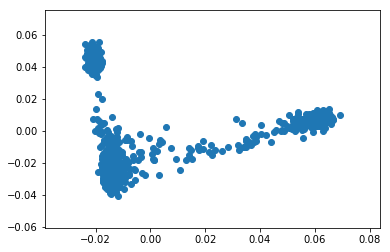

In [15]:
plt.scatter(v[:,0], v[:,1])